In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from lib.sin_cos_encode import SinCosEncode

In [2]:
! mkdir -p /app/.tensorboard/tst
! rm -rf /app/.tensorboard/tst/*

In [3]:
def months_diff(m1, m2):
    d1 = abs(m1 - m2)
    d2 = abs(m2 - 12 + m1)
    return min(d1, d2)

In [4]:
# generate training data - pairs of monts and shortest distance between them

months = np.repeat(np.arange(1, 13), 1024 * 32 + 1)
np.random.shuffle(months)

pairs = np.zeros((months.shape[0] - 1, 2))
diffs = np.zeros((pairs.shape[0]))

for i in range(len(months) - 1):
    pairs[i][0] = months[i]
    pairs[i][1] = months[i + 1]
    diffs[i] = months_diff(pairs[i][0], pairs[i][1])

In [5]:
def test_model(with_sincos, x, y):

    i1 = x = keras.layers.Input(shape=(2,), dtype="float32")
    if with_sincos:
        x = SinCosEncode(val_range=[1, 12])(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(1, activation="linear")(x)
    m = keras.Model(inputs=[i1], outputs=[x])

    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mae",
    )

    h = m.fit(
        x=pairs,
        y=diffs,
        verbose=0,
        batch_size=4096,
        epochs=25,
        callbacks=keras.callbacks.TensorBoard(log_dir="/app/.tensorboard/tst"),
    )

    return h, m

In [6]:
h1, m1 = test_model(with_sincos=False, x=pairs, y=diffs)
h2, m2 = test_model(with_sincos=True, x=pairs, y=diffs)

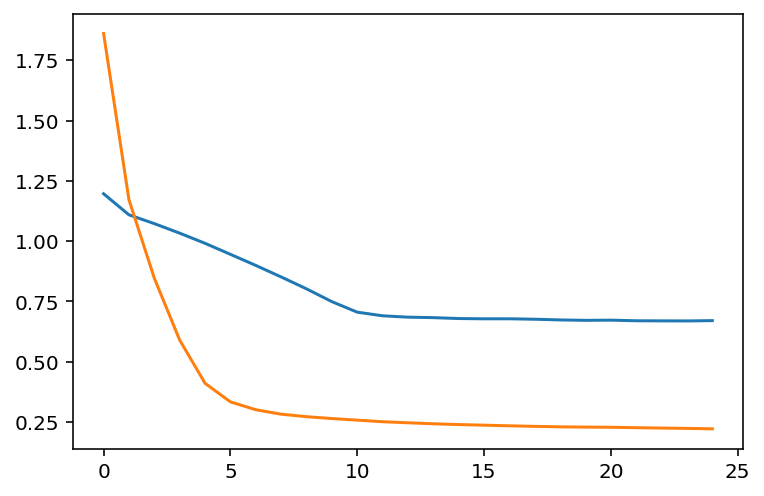

In [7]:
# losses without/with sin_cos
plt.plot(h1.history['loss'])
plt.plot(h2.history['loss'])

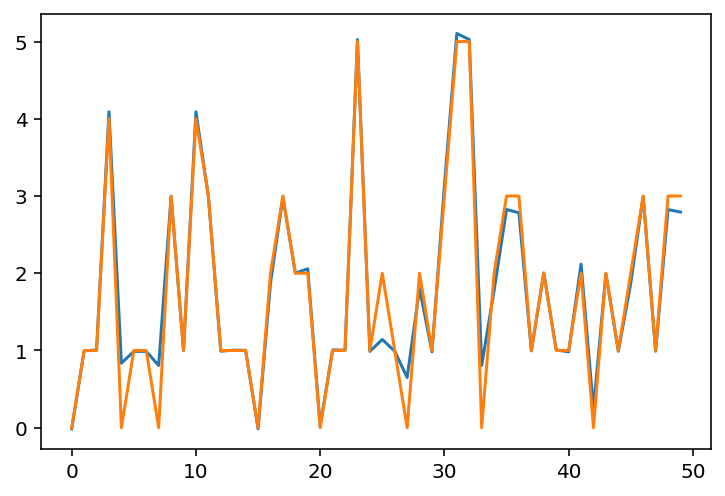

In [8]:
# predictions of sin_cos model agains months_diff function
r = pairs[100:150]
plt.plot(m2.predict(r))
plt.plot(list(map(months_diff, r[:, 0], r[:, 1])))